In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
class ReadImage():
    def __init__(self, image_path):
        self.image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        self.bisecting_line = None
        self.slope = None
        self.intercept = None

    def get_bisecting_line(self):
        region_1 = (self.image == 51).astype(np.uint8)
        contours, _ = cv2.findContours(region_1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cornea_contour = max(contours, key=cv2.contourArea)
        M = cv2.moments(cornea_contour)
        if M["m00"] != 0:
            cx_up = int(M["m10"] / M["m00"]) 
            cy_up = int(M["m01"] / M["m00"]) 
        else:
            cx_up, cy_up = 0, 0

        region_2 = (self.image == 153).astype(np.uint8) 
        contours, _ = cv2.findContours(region_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cornea_contour = max(contours, key=cv2.contourArea)
        M = cv2.moments(cornea_contour)
        if M["m00"] != 0:
            cx_lo = int(M["m10"] / M["m00"]) 
            cy_lo = int(M["m01"] / M["m00"]) 
        else:
            cx_lo, cy_lo = 0, 0

        x_centers = [cx_up, cx_lo]
        y_centers = [cy_up, cy_lo]
        m, b = np.polyfit(x_centers, y_centers, 1)
        x_values = np.array([0, self.image.shape[1]])  # Dynamic x range based on image width
        y_values = m * x_values + b
        self.slope = m
        self.intercept = b
        self.bisecting_line = [x_values, y_values]

        return self.bisecting_line

    def density_center(self):
        tolerance = 100
        region_width = 100

        slope = self.slope
        intercept = self.intercept

        tear_film = (self.image == 102).astype(np.uint8)
        highlighted_image = tear_film.copy()

        y_coords, x_coords = np.nonzero(tear_film)

        y_line_coords = slope * x_coords + intercept

        close_to_line_mask = np.abs(y_coords - y_line_coords) <= tolerance
        intersection_points = np.column_stack((x_coords[close_to_line_mask], y_coords[close_to_line_mask]))

        highlighted_image[y_coords[close_to_line_mask], x_coords[close_to_line_mask]] = 255
    
        if len(intersection_points) > 0:
            center_point = intersection_points[len(intersection_points) // 2]
            center_x, center_y = center_point

            region_width = 100  # Adjust

            left_x = center_x
            right_x = center_x

            while left_x > 0 and tear_film[center_y, left_x] > 0 and (center_x - left_x) <= region_width:
                highlighted_image[center_y, left_x] = 255
                left_x -= 1

            while right_x < highlighted_image.shape[1] and tear_film[center_y, right_x] > 0 and (right_x - center_x) <= region_width:
                highlighted_image[center_y, right_x] = 255 
                right_x += 1

        highlighted_region = tear_film[center_y, left_x:right_x+1]
        
        white_pixels = np.sum(highlighted_region > 0)

        total_white_pixels = np.sum(tear_film > 0)
        
        density = white_pixels / total_white_pixels if total_white_pixels > 0 else 0
        center_highlight = [[left_x, right_x], [center_y, center_y]]
        
        return density, center_highlight

    def density_edge_left(self):
        tear_film = (self.image == 102).astype(np.uint8)
        y_coords, x_coords = np.nonzero(tear_film)

        tolerance = 50 

        left_x = np.min(x_coords)

        left_y = y_coords[np.argmin(x_coords)]

        bottom_left_x = left_x
        bottom_left_y = left_y
        
        bottom_right_x = min(left_x + tolerance, 500) 
        up_left_y = max(left_y - tolerance, 0)

        mask = (x_coords >= bottom_left_x) & (x_coords <= bottom_right_x) & \
           (y_coords >= up_left_y) & (y_coords <= bottom_left_y)

        left_x_coords = x_coords[mask]
        left_y_coords = y_coords[mask]

        total_white_points = np.sum(tear_film > 0)
        edge_white_points = len(left_x_coords)
        density = edge_white_points / total_white_points if total_white_points > 0 else 0
    
        return density, left_x_coords, left_y_coords


    def density_edge_right(self):
        tear_film = (self.image == 102).astype(np.uint8)
        y_coords, x_coords = np.nonzero(tear_film)
        tolerance = 50 

        right_x = np.max(x_coords)

        right_y = y_coords[np.argmax(x_coords)]

        bottom_right_x = right_x
        bottom_right_y = right_y
        
        bottom_left_x = max(right_x - tolerance, 0) 
        up_right_y = max(right_y - tolerance, 0)

        mask = (x_coords >= bottom_left_x) & (x_coords <= bottom_right_x) & \
           (y_coords >= up_right_y) & (y_coords <= bottom_right_y)

        right_x_coords = x_coords[mask]
        right_y_coords = y_coords[mask]

        total_white_points = np.sum(tear_film > 0)
        edge_white_points = len(right_x_coords)
        density = edge_white_points / total_white_points if total_white_points > 0 else 0
    
        return density, right_x_coords, right_y_coords

    def plot_bisecting_line(self):
        x_values, y_values = self.bisecting_line
        plt.imshow(self.image, cmap='gray')
        plt.ylim(self.image.shape[0], 0)
        plt.plot(x_values, y_values, color='blue', linestyle='-', label='Line passing through centers')
        plt.ylim(500, 0)
        plt.title('Cornea with Bisecting Line')
        plt.show()

    def plot_center_density(self, center_highlight):
        plt.imshow(self.image, cmap='gray')
        plt.plot(center_highlight[0], center_highlight[1], color='red', linewidth=2)
        plt.title("Center Density Highlight")
        plt.show()

    def plot_edge_box_left(self, x_coords, y_coords):
        tear_film = (self.image == 102).astype(np.uint8)
        plt.imshow(tear_film, cmap='gray')

        for x, y in zip(x_coords, y_coords):
            plt.scatter(x, y, color='yellow', s=1)  # Scatter plot in yellow for each point
        
        plt.title("Image with Left Box Region Edges Highlighted")
        plt.show()
        

    def plot_edge_box_right(self, x_coords, y_coords):
        plt.imshow(self.image, cmap='gray')

        for x, y in zip(x_coords, y_coords):
            plt.scatter(x, y, color='yellow', s=1)  # Scatter plot in yellow for each point
        
        plt.title("Image with right Box Region Edges Highlighted")
        plt.show()

    def plot_all(self, center_highlight, left_box, right_box):
        self.plot_bisecting_line()
        self.plot_center_density(center_highlight)
        self.plot_edge_boxes(left_box, right_box)


In [4]:
img1 = ReadImage('SCL_OCT_dataset/label/CKY_OD_1H_img045_outcome.png')
line = img1.get_bisecting_line()
density, center_highlight = img1.density_center()
density_l, xl, yl = img1.density_edge_left()
density_r, xr, yr = img1.density_edge_right()

# Create Dataset

In [5]:
import os
import pandas as pd

columns = ['image_name', 'center_thickness', 'right_edge_thickness', 'left_edge_thickness']

image_dir = 'SCL_OCT_dataset/label/'  
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

In [9]:
all_cornea_data = []

for image_file in image_files:
    image_file = 'SCL_OCT_dataset/label/' + image_file
    img1 = ReadImage(image_file)
    line = img1.get_bisecting_line()
    density, center_highlight = img1.density_center()
    density_l, xl, yl = img1.density_edge_left()
    density_r, xr, yr = img1.density_edge_right()

    cornea_data = [image_file, density, density_r, density_l]
    all_cornea_data.append(cornea_data)

/var/folders/f4/4mwvrr4x2dg6l94x0rks7ypr0000gn/T/ipykernel_7606/393957604.py:31: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x_centers, y_centers, 1)
/var/folders/f4/4mwvrr4x2dg6l94x0rks7ypr0000gn/T/ipykernel_7606/393957604.py:31: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x_centers, y_centers, 1)
/var/folders/f4/4mwvrr4x2dg6l94x0rks7ypr0000gn/T/ipykernel_7606/393957604.py:31: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x_centers, y_centers, 1)
/var/folders/f4/4mwvrr4x2dg6l94x0rks7ypr0000gn/T/ipykernel_7606/393957604.py:31: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x_centers, y_centers, 1)
/var/folders/f4/4mwvrr4x2dg6l94x0rks7ypr0000gn/T/ipykernel_7606/393957604.py:31: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x_centers, y_centers, 1)
/var/folders/f4/4mwvrr4x2dg6l94x0rks7ypr0000gn/T/ipykernel_7606/393957604.py:31: RankWarning: Polyfit may be poorly conditioned
  m, b 

In [10]:
len(all_cornea_data)

1600

In [11]:
results_df = pd.DataFrame(all_cornea_data, columns=columns)

In [12]:
results_df

,image_name,center_thickness,right_edge_thickness,left_edge_thickness
0,SCL_OCT_dataset/label/XAQ_OS_I_img001_outcome.png,0.017383,0.061617,0.104579
1,SCL_OCT_dataset/label/ZJD_3_img035_outcome.png,0.017434,0.126947,0.057380
2,SCL_OCT_dataset/label/LYR_OD_I_img042_outcome.png,0.017160,0.103231,0.037941
3,SCL_OCT_dataset/label/YCL_OD_30min_img013_outc...,0.012872,0.031935,0.137860
4,SCL_OCT_dataset/label/ZXY_OD_4H_img036_outcome...,0.018604,0.088203,0.094112
...,...,...,...,...
1595,SCL_OCT_dataset/label/CKY_OD_1H_img011_outcome...,0.019384,0.104881,0.099515
1596,SCL_OCT_dataset/label/YCL_OD_I_img017_outcome.png,0.012219,0.042211,0.083056
1597,SCL_OCT_dataset/label/YCL_OD_1h_img064_outcome...,0.003836,0.082630,0.058082
1598,SCL_OCT_dataset/label/XAQ_OD_4h_img059_outcome...,0.018873,0.210801,0.096690


In [13]:
results_df.drop(['image_name'], axis = 1)

,center_thickness,right_edge_thickness,left_edge_thickness
0,0.017383,0.061617,0.104579
1,0.017434,0.126947,0.057380
2,0.017160,0.103231,0.037941
3,0.012872,0.031935,0.137860
4,0.018604,0.088203,0.094112
...,...,...,...
1595,0.019384,0.104881,0.099515
1596,0.012219,0.042211,0.083056
1597,0.003836,0.082630,0.058082
1598,0.018873,0.210801,0.096690


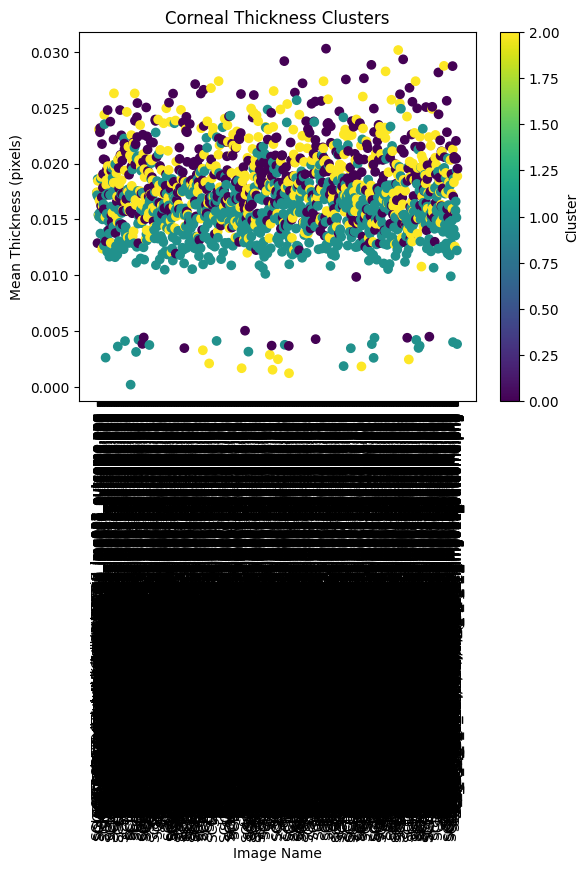

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


n_clusters = 3 

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
results_df['cluster'] = kmeans.fit_predict(results_df.drop(['image_name'], axis = 1))

plt.scatter(results_df['image_name'], results_df['center_thickness'], c=results_df['cluster'], cmap='viridis')
plt.title('Corneal Thickness Clusters')
plt.xlabel('Image Name')
plt.ylabel('Mean Thickness (pixels)')
plt.xticks(rotation=90)
plt.colorbar(label='Cluster')
plt.show()

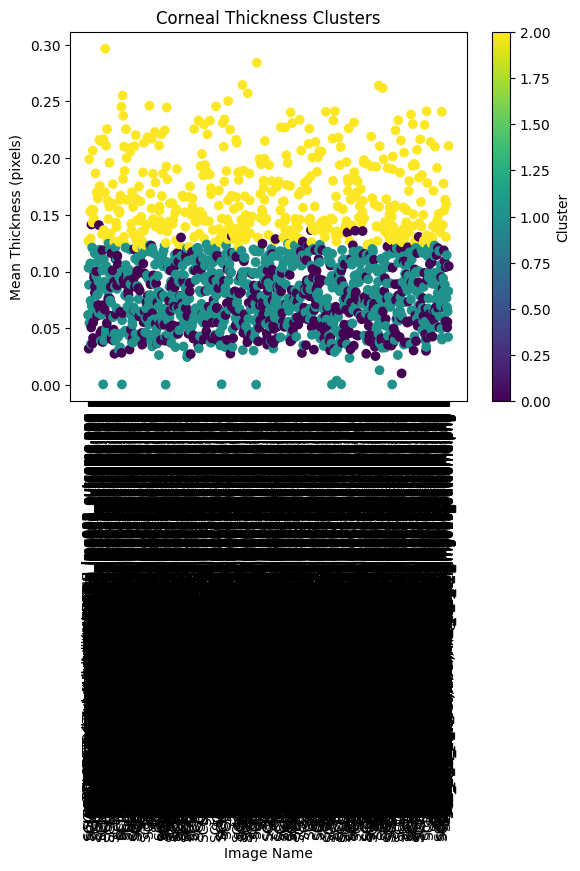

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


n_clusters = 3 

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
results_df['cluster'] = kmeans.fit_predict(results_df.drop(['image_name'], axis = 1))

plt.scatter(results_df['image_name'], results_df['right_edge_thickness'], c=results_df['cluster'], cmap='viridis')
plt.title('Corneal Thickness Clusters')
plt.xlabel('Image Name')
plt.ylabel('Mean Thickness (pixels)')
plt.xticks(rotation=90)
plt.colorbar(label='Cluster')
plt.show()

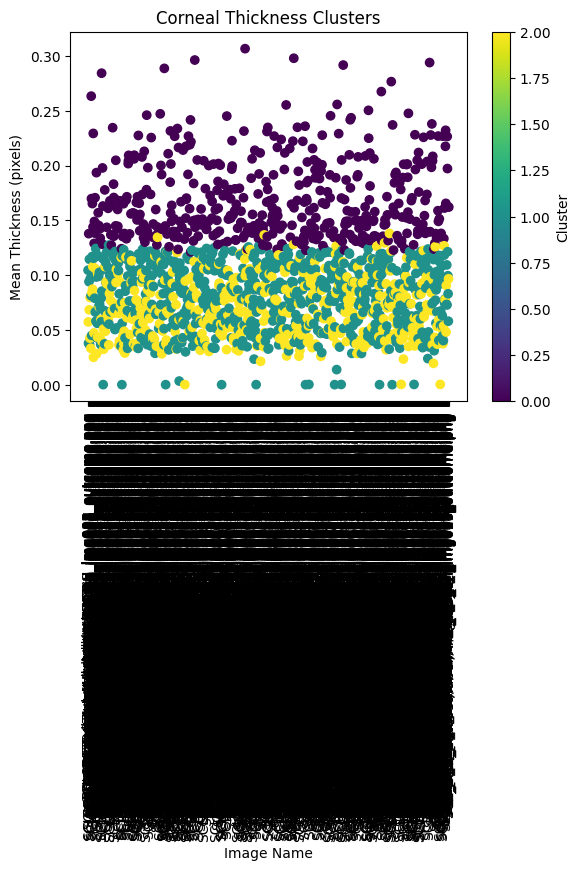

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


n_clusters = 3 

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
results_df['cluster'] = kmeans.fit_predict(results_df.drop(['image_name'], axis = 1))

plt.scatter(results_df['image_name'], results_df['left_edge_thickness'], c=results_df['cluster'], cmap='viridis')
plt.title('Corneal Thickness Clusters')
plt.xlabel('Image Name')
plt.ylabel('Mean Thickness (pixels)')
plt.xticks(rotation=90)
plt.colorbar(label='Cluster')
plt.show()